In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn.functional as Fchat
import random
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
def get_cifar100_loaders(batch_size=500):
	transform = transforms.Compose([
		transforms.RandomCrop(32, padding=4),
		transforms.RandomHorizontalFlip(),
		transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),  # 🔥 Stronger augmentation
		transforms.ToTensor(),
		transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
	])
	trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
	testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
	

	# Trim dataset to make it divisible by 5
	# Define split sizes (cumulative percentages: 20%, 40%, 60%, 80%, 100%)
	total_size = len(trainset)
	split_sizes = [int(total_size * p) for p in [0.2, 0.4, 0.6, 0.8, 1.0]]

	# Ensure the sum does not exceed dataset size (due to rounding)
	split_sizes[-1] = total_size  # Ensure last split gets exactly the full dataset

	# Perform the splits
	sub_datasets = [random_split(trainset, [s, total_size - s])[0] for s in split_sizes]
	sub_dataloaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in sub_datasets]

	testloader = DataLoader(testset, batch_size=500, shuffle=True, num_workers=1) #testloader always has size 500
	
	return sub_dataloaders, testloader

In [74]:
class ResidualBlock(nn.Module):
	def __init__(self, inchannel, outchannel, stride=1):
		super(ResidualBlock, self).__init__()

		self.pre_activations1 = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
			nn.BatchNorm2d(outchannel))
		
		self.pre_activations2 = nn.Sequential(
			nn.ReLU(),
			nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(outchannel)
		)

		self.shortcut = nn.Sequential()
		if stride != 1 or inchannel != outchannel:
			self.shortcut = nn.Sequential(
				nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(outchannel)
			)
			
	def forward(self, x):
		pre_activations = self.pre_activations1(x)
		pre_activations2 = self.pre_activations2(pre_activations)
		out = pre_activations2 + self.shortcut(x)
		out = F.relu(out)
		return out, pre_activations, pre_activations2

class ResNet(nn.Module):
	def __init__(self, ResidualBlock, num_classes=100):
		super(ResNet, self).__init__()
		self.inchannel = 64
		self.conv1 = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(64),
			nn.ReLU()
		)
		self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
		self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
		self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
		self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
		self.fc = nn.Linear(512, num_classes)
		
	def make_layer(self, block, channels, num_blocks, stride):
		strides = [stride] + [1] * (num_blocks - 1)
		layers = []
		for stride in strides:
			layers.append(block(self.inchannel, channels, stride))
			self.inchannel = channels
		return nn.ModuleList(layers)
	
	def forward(self, x):
		out = self.conv1(x)	
		pre_activations_list = []  # Store pre-activations
		
		pre_activations_list.append(out) # Pre-activation of the first layer

		# Iterate through each block to capture pre-activations
		for block in self.layer1:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer2:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		
		for block in self.layer3:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer4:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		

		out = F.avg_pool2d(out, 4)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out, pre_activations_list
	
def ResNet18():
	return ResNet(ResidualBlock)

In [75]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
	Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
	'''Pre-activation version of the BasicBlock.'''
	expansion = 1

	def __init__(self, in_planes, planes, stride=1):
		super(PreActBlock, self).__init__()
		self.bn1 = nn.BatchNorm2d(in_planes)
		self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
		self.bn2 = nn.BatchNorm2d(planes)
		self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

		if stride != 1 or in_planes != self.expansion*planes:
			self.shortcut = nn.Sequential(
				nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
			)

	def forward(self, x):
		out = F.relu(self.bn1(x))
		shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
		out = self.conv1(out)
		out = self.conv2(F.relu(self.bn2(out)))
		out += shortcut
		return out


class PreActBottleneck(nn.Module):
	'''Pre-activation version of the original Bottleneck module.'''
	expansion = 4

	def __init__(self, in_planes, planes, stride=1):
		super(PreActBottleneck, self).__init__()
		self.bn1 = nn.BatchNorm2d(in_planes)
		self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
		self.bn2 = nn.BatchNorm2d(planes)
		self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
		self.bn3 = nn.BatchNorm2d(planes)
		self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

		if stride != 1 or in_planes != self.expansion*planes:
			self.shortcut = nn.Sequential(
				nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
			)

	def forward(self, x):
		out = F.relu(self.bn1(x))
		shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
		out = self.conv1(out)
		out = self.conv2(F.relu(self.bn2(out)))
		out = self.conv3(F.relu(self.bn3(out)))
		out += shortcut
		return out


class PreActResNet(nn.Module):
	def __init__(self, block, num_blocks, num_classes=10):
		super(PreActResNet, self).__init__()
		self.in_planes = 64

		self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
		self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
		self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
		self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
		self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
		self.linear = nn.Linear(512*block.expansion, num_classes)

	def _make_layer(self, block, planes, num_blocks, stride):
		strides = [stride] + [1]*(num_blocks-1)
		layers = []
		for stride in strides:
			layers.append(block(self.in_planes, planes, stride))
			self.in_planes = planes * block.expansion
		return nn.Sequential(*layers)

	def forward(self, x):
		out = self.conv1(x)
		out = self.layer1(out)
		out = self.layer2(out)
		out = self.layer3(out)
		out = self.layer4(out)
		out = F.avg_pool2d(out, 4)
		out = out.view(out.size(0), -1)
		out = self.linear(out)
		return out


def PreActResNet18():
	return PreActResNet(PreActBlock, [2,2,2,2])

In [76]:
def compute_accuracy(preds, labels):
	"""
	Computes the accuracy given predicted labels and true labels.
	
	Args:
		preds (torch.Tensor): Predicted labels (tensor of shape [batch_size])
		labels (torch.Tensor): True labels (tensor of shape [batch_size])
	
	Returns:
		float: Accuracy percentage
	"""
	correct = (preds == labels).sum().item()  # Count correct predictions
	total = labels.size(0)  # Total number of samples
	accuracy = correct / total * 100  # Compute percentage
	return accuracy

In [77]:
# Function to update the running average
def update_running_avg(new_tensor, running_sum, count):
	count += 1
	running_sum += new_tensor
	running_avg = running_sum / count
	return running_avg, running_sum, count

In [ ]:
def test(model, device, test_loader, criterion, data_file, epoch, run, data_counter):
	"""Evaluates the model on the test dataset and computes loss & accuracy."""
	model.eval()  # Set model to evaluation mode
	total_loss = 0.0
	outputs = torch.tensor([]).to(device)
	mean_layer_act = torch.tensor([]).to(device)
	
	column_names = [f'Layer{i+1}' for i in range(17)] # Define column names for csv file
	column_names.extend(['acc', 'avg_loss', 'epoch', 'run', 'ammount_of_data']) # Add extra info columns

	# Initialize running sum and count
	running_sum = torch.zeros(17).to(device)  # 17 = Number of layers
	count = 0

	with torch.no_grad():  # Disable gradient calculation
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			for input, label in zip(inputs, labels):
				input, label = input.to(device), label.to(device)
				output, pre_act = model(input.unsqueeze(0))
				outputs = torch.cat((outputs, output))
				for layer in pre_act:
					mean_layer_act = torch.cat((mean_layer_act,torch.mean(layer).unsqueeze(dim=0)))

				running_avg, running_sum, count = update_running_avg(mean_layer_act, running_sum, count)
				mean_layer_act = torch.tensor([]).to(device)

			loss = criterion(outputs, labels)  # Compute loss
			total_loss += loss.item()
			
			preds = torch.argmax(outputs, dim=1)  # Get predicted labels
			
			break # We only need one batch

	acc = compute_accuracy(preds, labels)
	avg_loss = total_loss / len(test_loader)  # Average loss

	running_avg = torch.cat((running_avg, torch.tensor([acc, avg_loss, epoch, run, data_counter]).to(device))) # Add current epoch and run to the features
	
    # Convert to DataFrame (single row)
	df = pd.DataFrame([running_avg.cpu().numpy()], columns=column_names)

    # Append to CSV, write header only if the file does not exist
	df.to_csv(data_file, mode='a', header=not os.path.exists(data_file), index=False)

	print(acc, avg_loss)
	return avg_loss, acc

In [79]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait before stopping if no improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')  # Track best loss
        self.counter = 0  # Count epochs without improvement

    def __call__(self, avg_loss):
        """Returns True if training should stop."""
        if avg_loss < self.best_loss - self.min_delta:
            self.best_loss = avg_loss  # Update best loss
            self.counter = 0  # Reset counter
        else:
            self.counter += 1  # Increase counter if no improvement
        
        return self.counter >= self.patience  # Stop if patience is exceeded

In [ ]:
def train(model, device, train_loader, test_loader, criterion, optimizer, scheduler, run, data_counter, epochs=5):
	model.train()
	# Define CSV file path
	data_file = 'activations_per_layer.csv'
	early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # Adjust patience & delta

	dataset_size = len(train_loader.dataset)  # Get total dataset size
	progress_interval = int(dataset_size * 0.05)  # Compute 5% of dataset
	count = 0  # Initialize sample counter

	for epoch in range(epochs):

		for i, (inputs, labels) in enumerate(train_loader):
			count += len(inputs)  # Increment count by batch size
			inputs, labels = inputs.to(device), labels.to(device)
			
			optimizer.zero_grad()
			outputs, _ = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			
		if count % progress_interval < len(inputs):  # Print every 5% of dataset
			avg_loss, acc = test(model, device, test_loader, criterion, data_file, epoch, run, data_counter)
		
		# scheduler.step()
		
		if early_stopping(avg_loss):
			print("Early stopping triggered. Stopping training.")
			break  # Stop training

In [81]:
device = 'cuda'
# model = ResNet18()
# model.to(device)
num_runs = 5

train_loaders, test_loader = get_cifar100_loaders(128)
criterion = nn.CrossEntropyLoss()

data_counter = 0
for train_loader in train_loaders:

	for run in range(num_runs):
		model = ResNet18()
		model.to(device)
		optimizer = optim.Adam(model.parameters(), lr=0.001)
		# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # For 200 epochs

		train(model, device, train_loader, test_loader, criterion, optimizer, None, run, data_counter, epochs=100) #Train for x epochs or until early stopping

	data_counter += 1

500
3.2 0.22183995246887206
500
3.5999999999999996 0.22096688747406007
500
2.8000000000000003 0.21873393058776855
500
5.2 0.2136246919631958
500
4.6 0.21296963691711426
500
6.0 0.20842206478118896
500
6.0 0.20974299907684327


KeyboardInterrupt: 

In [40]:
# Replace 'your_file.csv' with the path to your CSV file
columns_to_exclude = ['acc', 'avg_loss', 'epoch', 'run']  # Replace with actual column names
df = pd.read_csv('activations_per_layer.csv')


# Drop the specified columns and compute the row-wise mean for the remaining columns
df['average'] = df.drop(columns=columns_to_exclude).mean(axis=1)


# df_avg['average'] = df_avg.mean(axis=1)

print(df)

       Layer1    Layer2    Layer3    Layer4    Layer5    Layer6    Layer7  \
0    0.211079  0.010234 -0.004218 -0.009240 -0.009463  0.006665  0.004965   
1    0.239452 -0.049766 -0.061672 -0.147841 -0.063707 -0.080705 -0.161174   
2    0.217504 -0.109261 -0.086958 -0.204223 -0.094630 -0.138829 -0.296986   
3    0.221867 -0.113259 -0.112986 -0.250318 -0.114973 -0.191888 -0.410430   
4    0.225897 -0.147568 -0.173410 -0.304189 -0.158085 -0.214572 -0.393810   
..        ...       ...       ...       ...       ...       ...       ...   
619  0.225790 -1.993813 -0.257890 -4.815207  0.024464 -2.443824 -1.982792   
620  0.208904 -1.837210 -0.236558 -4.237516 -0.005857 -2.038796 -1.932261   
621  0.206890 -1.791011 -0.222469 -4.098125 -0.020161 -1.908074 -2.196685   
622  0.221690 -1.955683 -0.249097 -4.393776 -0.026743 -2.126442 -1.961292   
623  0.214520 -1.813690 -0.303696 -4.354083 -0.057290 -2.037591 -1.980571   

        Layer8    Layer9   Layer10  ...   Layer13   Layer14   Layer15  \
0 

     time      mean
0       0 -0.029103
1       1 -0.157068
2       2 -0.160263
3       3 -0.156949
4       4 -0.186529
..    ...       ...
307   307 -3.836767
308   308 -3.942327
309   309 -3.897921
310   310 -3.801925
311   311 -3.838018

[312 rows x 2 columns]
     time       std
0       0  0.059395
1       1  0.069990
2       2  0.005551
3       3  0.000392
4       4  0.012295
..    ...       ...
307   307  0.017794
308   308  0.138525
309   309  0.249361
310   310  0.132020
311   311  0.009875

[312 rows x 2 columns]
     time      mean
155   155 -0.954181
156   156 -0.571100
157   157 -1.483093
158   158 -1.745369
159   159 -1.904512
160   160 -1.764108
161   161 -1.945316
162   162 -1.960811
163   163 -1.843228
164   164 -2.118504


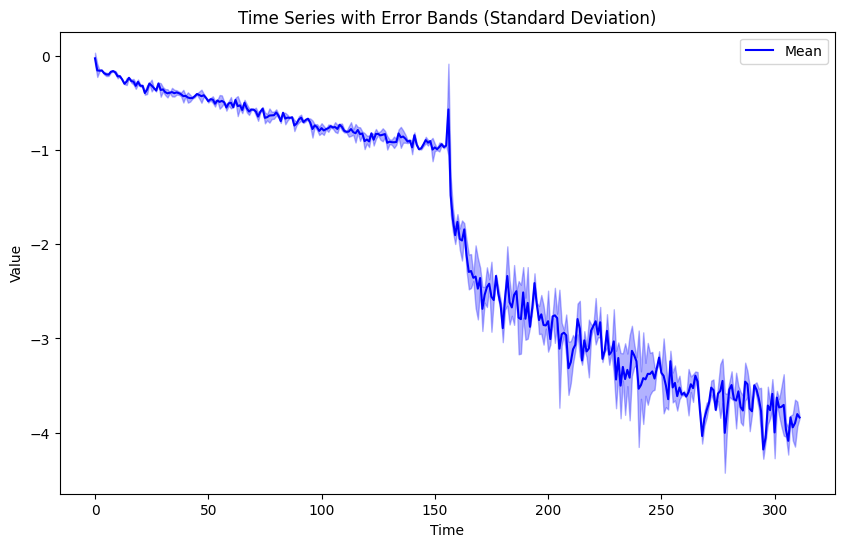

In [ ]:
# Create a 'time' column based on the order (index) of the rows
df['time'] = df.index // 2  # Assuming 3 runs per time point

# Calculate the mean and standard deviation for each time point
time_means = df.groupby('time')['average'].mean()
time_stds = df.groupby('time')['average'].std()

# Convert the mean and std into DataFrame for plotting
time_means_df = pd.DataFrame({'time': time_means.index, 'mean': time_means.values})
time_stds_df = pd.DataFrame({'time': time_stds.index, 'std': time_stds.values})

print(time_means_df)
print(time_stds_df)

# print(time_means_df.iloc[155:165])

# Plot the time series with error bands
plt.figure(figsize=(10, 6))

# Plot the mean values
sns.lineplot(x='time', y='mean', data=time_means_df, label='Mean', color='b')

# Add error bands
plt.fill_between(time_stds_df['time'], 
                 time_means_df['mean'] - time_stds_df['std'], 
                 time_means_df['mean'] + time_stds_df['std'], 
                 color='blue', alpha=0.3)

plt.title("Time Series with Error Bands (Standard Deviation)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()